# <center>Eksploracja zbioru danych `Asian Religions Data` </center>

In [1]:
# Pakiety
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from collections import Counter 
import matplotlib.pyplot as plt
import re
plt.rcParams["figure.figsize"] = (20,10)
# Ustawienie ziarna, pozwala zachować reprodukowalność wyników
np.random.seed(123)

In [2]:
# Wczytanie danych
data = pd.read_csv("./AsianReligionsData/AllBooks_baseline_DTM_Labelled.csv")
data.rename(columns={'Unnamed: 0':'Text'}, inplace=True)

Większość tekstów w tym zbiorze danych zebrano z projektu Gutenberg. W zbiorze uwzględnioro się 8 ksiąg religijnych, w badaniu rozważono 8265 słów.

In [3]:
# Sprawdzenie wymiarów zbioru oraz obecnych w nim typów danych.
print('\033[1m' + 'Asian Religions Data:' + '\033[0m')
data.info()

Asian Religions Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Columns: 8267 entries, Text to explains
dtypes: int64(8266), object(1)
memory usage: 37.2+ MB


Poza pierwszym artybutem, tożsamym z nazwą/rozdziałem księgi, wszystkie zmienne objaśniające mają charakter liczbowy.

In [4]:
# Sprawdzenie zbioru pod kątem obecności braków danych.
data.isnull().values.any()

False

W zbiorze nie występują braki danych. Dane nie wymagają czyszczenia.

In [5]:
def scaller(df):
    # Skalowanie danych numerycznych
    num = df.select_dtypes(include=['float64', 'int64']).columns
    df2 = df.copy()
    scaler = StandardScaler()
    df2[num] = scaler.fit_transform(df2[num])
    return(df2)

In [6]:
def correlated_pairs(df):
    df2 = scaller(df)
    # Bezwzględne korelacje zmiennych
    corr=df2.iloc[:, 1:].corr().abs()
    # Z powodu symetrii macierzy wybieramy podmacierz trójkątną górną bez diagonali
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    triu = upper.unstack().sort_values(ascending=False)
    # Wybór najsilniej skorelowanych par zmiennych
    result = triu[triu >= 0.8]
    return result

result = correlated_pairs(data)

In [7]:
result

breathes      neitherpainfulnorpleasant    1.000000
smoulder      blaze                        1.000000
extend        thoroughbreds                1.000000
establisheth  resisteth                    1.000000
secondly      colt                         1.000000
                                             ...   
extent        disposed                     0.800131
              apprentice                   0.800131
apprentice    tendons                      0.800131
mindful       culmination                  0.800095
internal      winds                        0.800008
Length: 35328, dtype: float64

In [8]:
result.describe()

count    35328.000000
mean         0.966030
std          0.061034
min          0.800008
25%          0.948630
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

Niektóre pary wyrazów są bardzo silnie skorelowane.

In [9]:
# Przekształcenie kolumn na wektory
# Funkcja przyjmuje na wejściu ramkę danych,
# na wyjściu zwraca słownik o strukturze: klucz - słowo, wartość - wektor
def to_embedding_dict(data):
    data1 = scaller(data)
    # Tworzenie słownika
    embeddings_dict = {}
    for col in data1.columns:
        if col == data1.columns[0]:
            continue
        word = col.lower()
        vector = np.asarray(data1.loc[:, [col]])
        embeddings_dict[word] = vector
    return(embeddings_dict)

In [10]:
embedding_dict = to_embedding_dict(data)

In [11]:
# Funkcja znajdująca tablicę najbliższych sąsiadów (kluczy) najbliższych sąsiadów klucza 
# podanego na wejściu. Czyli w efekcie słów, które występują równie często, co słowo
# podane na wejściu. Pozwala też sprawdzić czy dane słowo w ogóle występuje w słowniku.
def nearest_neigh(key):
    # Sprawdzenie czy w słowniku znajduje się wprowadzony klucz
    if not key in list(embedding_dict.keys()):
        return None
    # Zmienne pomocnicze
    min_dist = float('inf')
    nearest = []
    # Szukanie najbliższego klucza
    for k in list(embedding_dict.keys()):
        if k == key:
            continue
        dist = np.linalg.norm(embedding_dict.get(k)-embedding_dict.get(key))
        if dist < min_dist:
            min_dist = dist
            nearest = []
            nearest.append(k)
        # Przypadek gdy mamy kilka "równoodległych" kluczy
        elif dist == min_dist:
            nearest.append(k)
    return nearest

In [12]:
# Sprawdzenie rzeczowników wymienionych wśród najczęściej występujących w Biblii
print(nearest_neigh('lord'))
print(nearest_neigh('god'))
print(nearest_neigh('mercy'))
print(nearest_neigh('jesus'))
print(nearest_neigh('faith'))
print(nearest_neigh('evil'))
print(nearest_neigh('spirit'))

['fear']
['hath']
['riotous', 'perfections', 'praying', 'borrowing', 'tempteth', 'repaying', 'assuage', 'pebble', 'concertation']
['bibles', 'bethhoron', 'protested', 'beset', 'caleb', 'josue', 'lords', 'floweth', 'jos', 'samuel', 'jephone', 'successor', 'withholding', 'shoe', 'tyrians', 'thundered', 'appeasing', 'stopped', 'resisted', 'assaulted']
['dispensed', 'dealeth', 'scarcely', 'replenisheth', 'charge', 'concert', 'emerald', 'elder', 'acquitted', 'valour', 'carbuncle']
['good']
['dieth']


In [13]:
# Najczęściej występujące w ramce słowa 
def most_frequent_words(data,n=10):
    words = data.columns
    words = np.delete(words,0)
    words_counter = np.array([0]*8266)
    for i in range(len(data.iloc[:,1])):
        row = np.array(data.iloc[i,:])

        row = np.delete(row,0)
        words_counter= words_counter+row 
    out = dict(zip(words,words_counter))
    out = Counter(out)
    return dict(out.most_common(n))
    

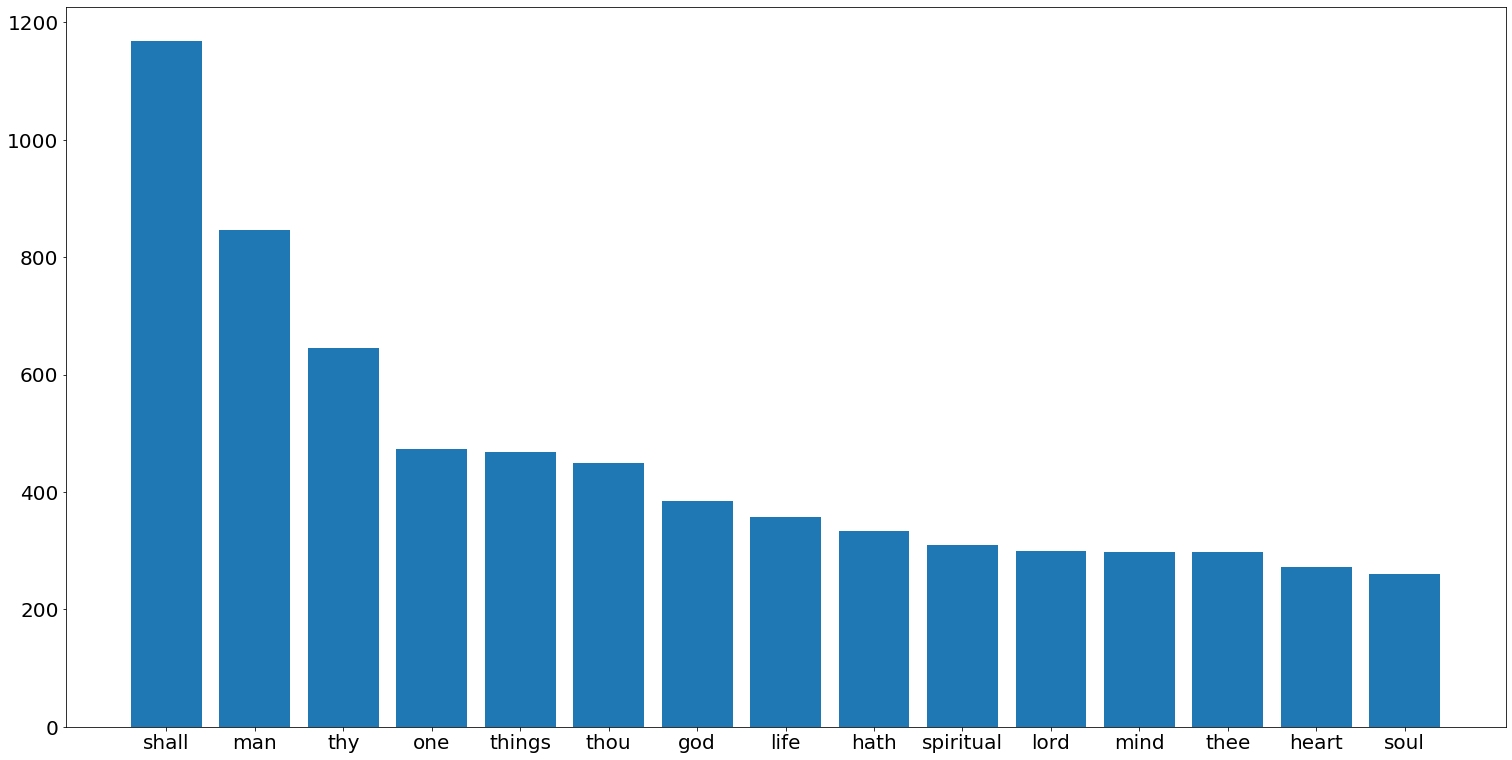

In [14]:
most = most_frequent_words(data,n =15 )


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = list(most.values())
students = most.keys()
ax.tick_params(axis='both', which='major', labelsize=20)
ax.bar(students,langs)
plt.show()

Nie wchodząc na razie w szczegóły warto zauważyć że nie pojawiły się słowa takie jak 'and' albo 'is' co może świadczyć o ich braku. Zbiór prawdopodobnie został wyczyszczony (choć nie koniecznie).

In [15]:
# Sprawdźmy czy faktycznie w zbiorze nie ma słow 'and' i 'is'
print(nearest_neigh('and'))
print(nearest_neigh('is'))
print(nearest_neigh('of'))
print(nearest_neigh('to'))

None
None
None
None


Ramka danych jest pozbawiona typowych angielskich wyrazów. Choć nie wszystkich:

In [16]:
print(nearest_neigh('the'))

['inaudible', 'unwinding', 'description', 'clue', 'indeterminable']


In [17]:
# Sprawdzę czy zostały usuniete różne formy poszczegółnych słow spodziewam się że tak dla tego wykonam tylko 
# kilka testów 
def test(word):
    import re
    index = [False]*8267
    for i in range(len(data.columns)):
        o =re.match(word,data.columns[i])

        if o!=None:
            index[i]=True
    return data.columns[index] 
print(test('god'))
# Słowa takie jak gods czy godly budzą wątpliwości czy hipoteza była słuszna i byc może trzeba będzie zastosować
# jakiś sposób aby połączyć je w jedno 

Index(['godvision', 'godly', 'godenlightened', 'god', 'godliness', 'godward',
       'gods', 'godlike'],
      dtype='object')


In [18]:
# Sprawdzę jescze inne słowa 
print(test('and')) # brak 
print(test('man')) # potwierdza to co pokazuje 'god'

Index([], dtype='object')
Index(['manifested', 'manifold', 'mansions', 'manifestly', 'mankind',
       'manifestations', 'manhood', 'manner', 'manna', 'managing', 'mantram',
       'manages', 'many', 'manycoloured', 'manifesting', 'manners', 'manacles',
       'manifestation', 'managed', 'manifests', 'manes', 'manifest', 'man',
       'mansion', 'manageable'],
      dtype='object')


Możliwe, że pomocne przy klasteryzacji okaże się zastosowanie odległości Levenshteina i przetworzenie danych tak aby słowa 'god' 'godes' były liczone razem ale biorąc pod uwagę naturę tekstów (religine) drobne różnice mogą mieć duże znaczenie, więc na razie pozostaje to tylko hipotezą. 

In [19]:
# W zbiorze mamy księgi podzielone na rozdziały sprawdzę różnicę w częstości słow dla poszczególnych ksiąg 
data_books = data.copy()
# Generowanie tytułów ksiąg
names = []
for i in range (len(data)):
    
    names.append(re.findall('([^_]+)',data_books.iloc[i,0])[0])
names = np.unique(names)


# index for selected book 
def index_selected_book(book):
    index = [False] * 590
    for i in range(len(data)):
        
        if book == re.findall('([^_]+)',data_books.iloc[i,0])[0]:
            index[i] = True 
    index_number = [ ]
    j = 0 
    for i in index:
        if i:
            index_number.append(j)
        j+=1 
    return index_number

# Generowanie ramki z informacjami
def information_most_frequent(data,names):
    
    result = []
    
    for i in names:
        w = most_frequent_words(data.iloc[index_selected_book(i),:])
        result.append([i,w])
    
    return result

In [20]:
information_most_frequent(data,names)

[['BookOfEccleasiasticus',
  {'shall': 508,
   'thy': 330,
   'man': 232,
   'thou': 230,
   'god': 193,
   'hath': 189,
   'thee': 170,
   'lord': 152,
   'things': 120,
   'upon': 115}],
 ['BookOfEcclesiastes',
  {'shall': 89,
   'man': 71,
   'hath': 46,
   'things': 46,
   'god': 46,
   'thy': 43,
   'time': 42,
   'sun': 36,
   'also': 31,
   'vanity': 29}],
 ['BookOfProverb',
  {'shall': 389,
   'man': 176,
   'thy': 165,
   'thou': 93,
   'wicked': 92,
   'lord': 85,
   'wise': 71,
   'hath': 65,
   'heart': 64,
   'thee': 59}],
 ['BookOfWisdom',
  {'shall': 120,
   'things': 89,
   'thy': 86,
   'god': 67,
   'thou': 61,
   'wisdom': 38,
   'man': 38,
   'upon': 37,
   'made': 35,
   'hath': 32}],
 ['Buddhism',
  {'right': 128,
   'feeling': 85,
   'one': 75,
   'stress': 74,
   'body': 73,
   'monk': 72,
   'mind': 71,
   'remains': 63,
   'cessation': 62,
   'called': 62}],
 ['TaoTeChing',
  {'tao': 84,
   'things': 56,
   'one': 51,
   'men': 45,
   'great': 42,
   'therefor

Widać wyrażne różnice po między różnymi tekstami choć wydaje się że słowa takie jak 'one','man','god','shall' powtarzają się częściej niż inne, choć dla poszczególnych ksiąg wcale nie muszą występować najczęściej.

W sprawie grupowania podobnych słów: nie wiem, na ile to legalne, ale proponowałbym pobrać jakiś zbiór możliwie bazowych form słów w języku angielskim. Następnie wyszukać te formy wśród naszych słów i po ich wyznaczeniu zgrupować je z ich odmianami (słowami spoza takiej bazy). Odpowiednim regeksem typu "^"+słowo, od najdłuższego takiego podstawowego słowa, żeby nie uznano odmiany _manifest_ jako pochodzącej od _man_. Nie wiem jeszcze, jak oddzielić _man_ od *many*, a jednocześnie _manifest_ od _manifestation_.

Na ten moment zaimplementuję trochę inny, bardziej _intuicyjny_ algorytm:

In [3]:
# spis kolumn
kolumny = data.columns[1:]
COLS = kolumny.sort_values()

# grupy słów (niżej wytłumaczenie działania)
def groups(words):
    groupsL = []
    i = 0
    j = 0
    mainword = []
    while j < 8266:
        if not re.findall('^' + words[i], words[j]) == []:
            mainword.append(words[j])
            j = j + 1
        else:
            groupsL.append(mainword)
            mainword = []
            i = j
    return groupsL
groups(COLS)[:50]

[['FALSE'],
 ['TRUE'],
 ['aaron'],
 ['abandon', 'abandoned', 'abandoning', 'abandons'],
 ['abase', 'abasement'],
 ['abashed'],
 ['abasing'],
 ['abated'],
 ['abates'],
 ['abateth'],
 ['aberrant'],
 ['abhor', 'abhorred', 'abhorreth'],
 ['abide', 'abides', 'abideth'],
 ['abiding', 'abidingplace'],
 ['abilities'],
 ['ability'],
 ['abiron'],
 ['able'],
 ['abnormal'],
 ['abode', 'abodes'],
 ['abolish', 'abolished'],
 ['abominable'],
 ['abomination', 'abominations'],
 ['abound', 'abounded', 'aboundeth'],
 ['abraham'],
 ['abroad'],
 ['absence'],
 ['absent'],
 ['absolute', 'absolutely'],
 ['absorbed'],
 ['absorbing'],
 ['absorption'],
 ['abstain', 'abstaineth', 'abstaining', 'abstains'],
 ['abstinence', 'abstinences'],
 ['abstract'],
 ['abundance'],
 ['abundant', 'abundantly'],
 ['abuse'],
 ['abusive'],
 ['abysmal'],
 ['abyss'],
 ['accept', 'acceptable', 'acceptance', 'accepted', 'accepts'],
 ['accessary'],
 ['accidental'],
 ['accidents'],
 ['acclimatization'],
 ['accompanied'],
 ['accomplish',

In [22]:
len(groups(COLS))

2703

Słowa zostały uporządkowane alfabetycznie i zgrupowane w taki sposób, żeby pierwsze słowo w każdej grupie zaczynało wszystkie następne. W większości przypadków wygląda to sensownie, ale problem sprawiają przypadki typu "add/address/adds" i "man/manifest/mankind". Planujemy to dopracować.

Tymczasem, o co chodzi z kolumnami TRUE i FALSE?

In [4]:
dtrue = data.TRUE
dtrue.describe()

count    590.000000
mean       0.142373
std        0.440020
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: TRUE, dtype: float64

In [5]:
dfalse = data.FALSE
dfalse.describe()

count    590.000000
mean       0.030508
std        0.199536
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: FALSE, dtype: float64

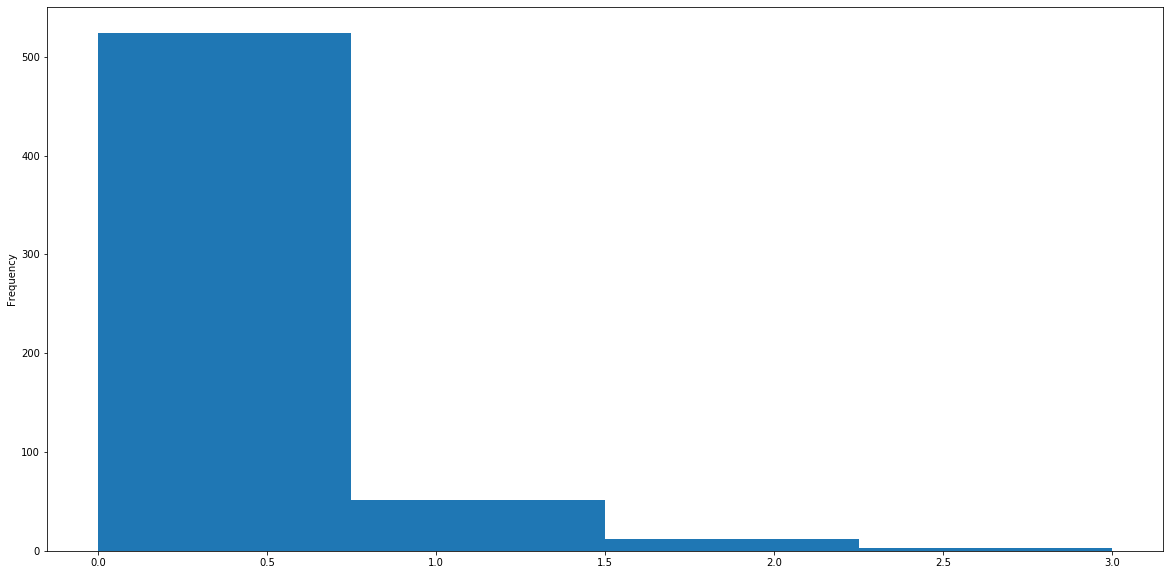

In [25]:
dtrue.plot(kind="hist", bins=4)

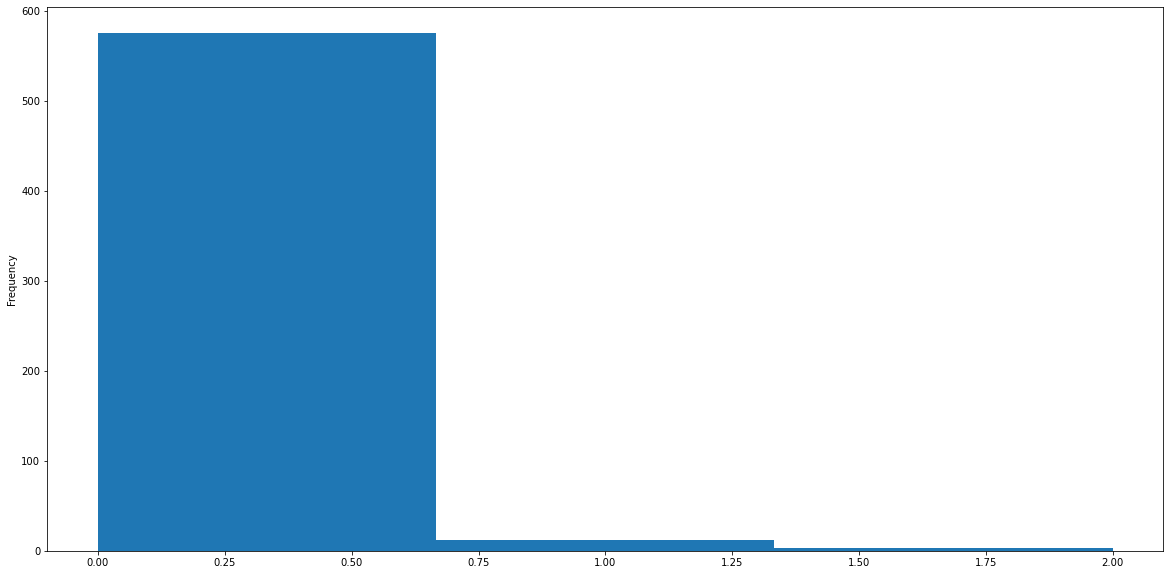

In [7]:
dfalse.plot(kind="hist", bins=3)

In [27]:
trufals = pd.concat([dtrue.reset_index(drop=True), dfalse], axis=1)
information_most_frequent(trufals, names)

[['BookOfEccleasiasticus', {'FALSE': 5}],
 ['BookOfEcclesiastes', {'FALSE': 0}],
 ['BookOfProverb', {'FALSE': 3}],
 ['BookOfWisdom', {'FALSE': 0}],
 ['Buddhism', {'FALSE': 2}],
 ['TaoTeChing', {'FALSE': 1}],
 ['Upanishad', {'FALSE': 0}],
 ['YogaSutra', {'FALSE': 7}]]

Takich słów nie udało mi się znaleźć w oryginalnym tekście, w związku z czym sugeruje się ich usunięcie.